In [2]:
import pandas as pd
%run utils.ipynb

In [3]:
# data_paths = load_data_paths("out_paths")

# dos_df_path = data_paths["dos_df"]
# fuzzy_df_path = data_paths["fuzzy_df"]
# attack_free_df_path = data_paths["attack_free_df"]

# dos_df = pd.read_csv(dos_df_path)
# fuzzy_df = pd.read_csv(fuzzy_df_path)
# attack_free_df = pd.read_csv(attack_free_df_path)
dos_df,fuzzy_df,attack_free_df=load_data("out_paths",lib="pd")


# Exploratory Data Analysis

## Common Methods

In [4]:
bytes_col_list=[col for col in dos_df.columns if col.startswith("byte")]

In [5]:
def show_shape_info_of_data(data):
    print("Data Shape")
    print("*" * 40)
    print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
    print("\nInfo")
    print("*" * 40)
    info_dict={
        "Column": data.columns,
        "Data Type": data.dtypes,
        "Null Count": data.isnull().sum(),
        "Unique Count":data.nunique()}
    info_df = pd.DataFrame(info_dict)
    print(info_df.to_string(index=False))


In [6]:
def concatenate_columns(cols, new_column_name,data):
    """
    Merges multiple columns into a single column by concatenating their values.

    Parameters
    ----------
    cols : list[str]
        List of column names to be merged.
    new_column_name : str
        Name of the new column that will store the merged values.
    data : pd.DataFrame
        The DataFrame containing the columns to be merged.

    Returns
    -------
    pd.DataFrame
        Updated DataFrame with the new merged column.
    """
    data[new_column_name] = ""
    for col in cols:
        data[new_column_name] += data[col]
    return data


In [7]:
def convert_timestamp_to_datetime(col_to_be_added_name,existing_col_name, data):
    """
    Convert timestamp column to a datetime column .

    Parameters
    ----------
    col_to_be_added_name : str
        Name of the new column to store the converted datetime values.
    existing_col_name : _type_
        Name of existing column containing timestamps in seconds
    data : pd.DataFrame
        DataFrame containing the existing column.

    Returns
    -------
    pd.DataFrame
        DataFrame with the new datetime column added
    """

    data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')
    return data

In [8]:
def extract_datetime_components(existing_col_name,data):
    """
    Extracts year, month, day, and hour from a datetime column and adds them as new columns.

    Parameters
    ----------
    existing_col_name : str
        The name of the column containing datetime values.
    data : pd.DataFrame
        The DataFrame containing the datetime column.

    Returns
    -------
    pd.DataFrame
        DataFrame with added columns: 'year', 'month', 'day', and 'hour'.
    """
    data['year'] = data[existing_col_name].dt.year
    data['month'] = data[existing_col_name].dt.month
    data['day'] = data[existing_col_name].dt.day
    data['hour']=data[existing_col_name].dt.hour

    return data


In [9]:
def print_start_end_timestamps(data,column_name):
    """
    Prints the start and end timestamps from a specified column in a DataFrame.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing the timestamp column.
    column_name : str
        The name of the column containing timestamp values.

    Returns
    -------
    None
        This function prints the start and end timestamps but does not return anything.
    """
    print("Start Time: ",data[column_name].iloc[0])
    print("End Time: ",data[column_name].iloc[-1])

In [10]:
def convert_hex_to_int(value):
    """
    Converts a hexadecimal string to an integer. If the value is already an integer, it is returned as is.

    Parameters
    ----------
    value : str | int
        The value to convert. If a string, it should represent a valid hexadecimal number.

    Returns
    -------
    int
        The converted integer value.

    Raises
    ------
    ValueError
        If the string is not a valid hexadecimal number.
    """
    if isinstance(value, str):
        try:
            return int(value,16)
        except ValueError:
            raise ValueError(f"Invalid hexadecimal value: {value}")
    return value  

In [11]:
def convert_hex_bytes_to_int(data,bytes_col_list):
    """
    Convert hexadecimal byte values in specified columns to integers.

    Parameters
    ----------
    data : pandas.DataFrame
        The DataFrame containing the columns to convert.
    bytes_col_list : list
        A list of column names containing hexadecimal values as strings.

    Returns
    -------
    pandas.DataFrame
        The modified DataFrame with specified columns converted to integers.
    """
    for col in bytes_col_list:
        if col in data.columns:
            data[col] = data[col].apply(convert_hex_to_int)
    return data
    

In [12]:
def print_unique_datetime_components (data):
    """
    Prints the unique values of the 'day', 'month', 'year', and 'hour' columns in a DataFrame.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing 'day', 'month', 'year', and 'hour' columns.

    Returns
    -------
    None
        This function prints unique values but does not return anything.
    """
    for col in ['day','month','year','hour']:
        print(col,data[col].unique())

## DoS

In [13]:
show_shape_info_of_data(dos_df)

Data Shape
****************************************
Rows: 3665770, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0       3665770
      can_id    object           0            27
         dlc     int64           0             2
      byte_0    object           0           108
      byte_1    object           0            71
      byte_2    object       31188            75
      byte_3    object       31188            26
      byte_4    object       31188           190
      byte_5    object       31188           256
      byte_6    object       31188            75
      byte_7    object       31188           256
updated_flag    object           0             2


In [14]:
dos_df.head()

,timestamp,can_id,dlc,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,updated_flag
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [15]:
dos_df=convert_timestamp_to_datetime("datetime","timestamp", dos_df)


In [16]:
print_start_end_timestamps(dos_df,"datetime")


Start Time:  2016-11-03 18:39:36.389636040
End Time:  2016-11-03 19:26:49.058943987


In [17]:
dos_df=extract_datetime_components("datetime",dos_df)

In [18]:
print_unique_datetime_components (dos_df)

day [3]
month [11]
year [2016]
hour [18 19]


In [19]:
col="can_id"
dos_df["updated_can_id"] = dos_df[col].apply(convert_hex_to_int)

In [20]:
# dos_df["updated_can_id"].value_counts()

In [21]:
col="dlc"
dos_df[col].value_counts()

dlc
8    3634582
2      31188
Name: count, dtype: int64

In [22]:
dos_df=concatenate_columns(bytes_col_list,"merged_bytes",dos_df)
col="merged_bytes"
dos_df[col].nunique()

66913

In [23]:
dos_df[bytes_col_list].head()

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7
0,fe,5b,00,00,00,3c,00,00
1,19,21,22,30,08,8e,6d,3a
2,64,00,9a,1d,97,02,bd,00
3,40,bb,7f,14,11,20,00,14
4,d8,00,00,8a,00,00,00,00


In [24]:
dos_df=convert_hex_bytes_to_int(dos_df,bytes_col_list)

In [25]:
dos_df[bytes_col_list].head()

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7
0,254,91,0.0,0.0,0.0,60.0,0.0,0.0
1,25,33,34.0,48.0,8.0,142.0,109.0,58.0
2,100,0,154.0,29.0,151.0,2.0,189.0,0.0
3,64,187,127.0,20.0,17.0,32.0,0.0,20.0
4,216,0,0.0,138.0,0.0,0.0,0.0,0.0


In [26]:
#T or R, T represents injected message while R represents normal message
col="updated_flag"
dos_df[col].value_counts()

updated_flag
R    3078249
T     587521
Name: count, dtype: int64

### Insights about DoS Attack

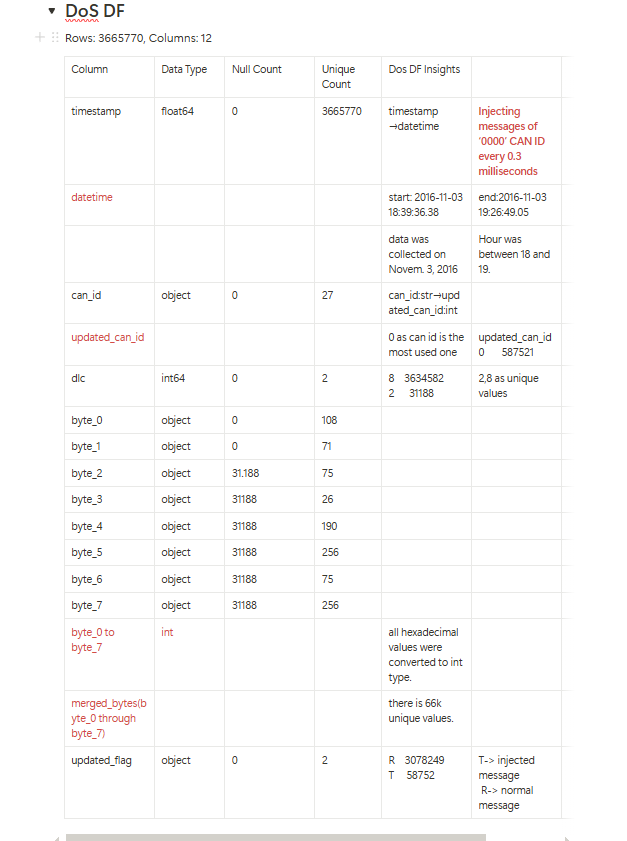

## Fuzzy

In [27]:
show_shape_info_of_data(fuzzy_df)

Data Shape
****************************************
Rows: 3838859, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0       3838859
      can_id    object           0          2048
         dlc     int64           0             4
      byte_0    object           0           256
      byte_1    object           0           256
      byte_2    object       34382           256
      byte_3    object       34382           256
      byte_4    object       34382           256
      byte_5    object       87833           256
      byte_6    object       87836           256
      byte_7    object       87836           256
updated_flag    object           0             2


In [28]:
fuzzy_df=convert_timestamp_to_datetime("datetime","timestamp", fuzzy_df)


In [29]:
print_start_end_timestamps(fuzzy_df,"datetime")

Start Time:  2016-11-03 17:55:21.905735970
End Time:  2016-11-03 19:26:49.058943987


In [30]:
fuzzy_df=extract_datetime_components("datetime",fuzzy_df)

In [31]:
print_unique_datetime_components (fuzzy_df)

day [3]
month [11]
year [2016]
hour [17 18 19]


In [32]:
col="can_id"
fuzzy_df["updated_can_id"] = fuzzy_df[col].apply(convert_hex_to_int)

In [33]:
col="updated_can_id"
fuzzy_df[col].value_counts()[:30]

updated_can_id
790     182121
2       180011
399     179802
704     179637
1087    179538
848     178687
339     178188
304     178149
608     178049
880     177691
672     177174
305     176116
809     175761
1088    175479
320     175211
1349    173707
1072     92917
1201     90109
497      89766
1264     88946
688      53477
1520     34617
160      18266
161      17930
1680     17880
1440      1988
1442      1932
1706       458
1999       446
802        294
Name: count, dtype: int64

In [34]:
col="dlc"
fuzzy_df[col].value_counts()

dlc
8    3751023
5      53451
2      34382
6          3
Name: count, dtype: int64

In [35]:
fuzzy_df=concatenate_columns(bytes_col_list,"merged_bytes",fuzzy_df)

In [36]:
col="merged_bytes"
fuzzy_df[col].nunique()

560012

In [37]:
fuzzy_df=convert_hex_bytes_to_int(fuzzy_df,bytes_col_list)

In [38]:
fuzzy_df[bytes_col_list].head()

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7
0,255,127,0.0,5.0,73.0,NaN,NaN,NaN
1,0,0,0.0,0.0,0.0,1.0,7.0,21.0
2,0,33,16.0,255.0,0.0,255.0,0.0,0.0
3,25,128,0.0,255.0,254.0,127.0,7.0,96.0
4,23,128,0.0,0.0,101.0,127.0,7.0,159.0


In [39]:
fuzzy_df["updated_flag"].value_counts()

updated_flag
R    3347012
T     491847
Name: count, dtype: int64

### Insights about Fuzzy Attack

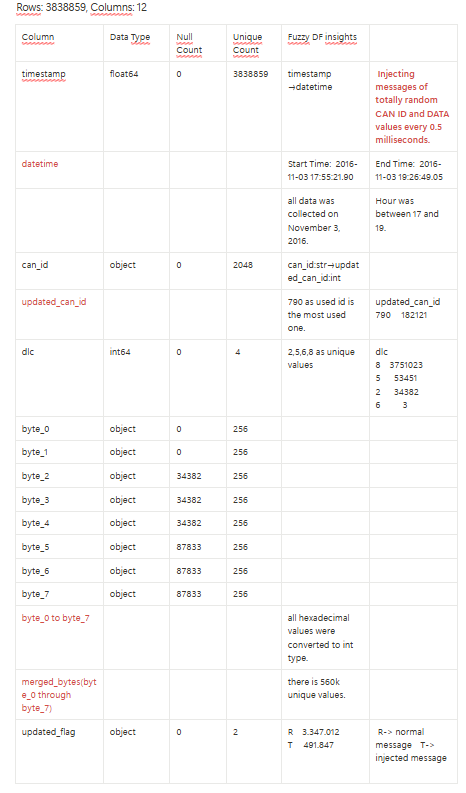

## Attack Free

In [40]:
show_shape_info_of_data(attack_free_df)

Data Shape
****************************************
Rows: 988871, Columns: 12

Info
****************************************
    Column Data Type  Null Count  Unique Count
 timestamp   float64           0        988871
    can_id    object           0            27
frame_type     int64           0             1
       dlc     int64           0             3
    byte_0    object           0           256
    byte_1    object           0           256
    byte_2    object       10129           256
    byte_3    object       10129           256
    byte_4    object       10129           256
    byte_5    object       60735           256
    byte_6    object       60735           227
    byte_7    object       60735           256


In [41]:
col="timestamp"
attack_free_df=convert_timestamp_to_datetime("datetime","timestamp", attack_free_df)


In [42]:
print_start_end_timestamps(attack_free_df,"datetime")

Start Time:  2016-11-14 11:03:54.850202084
End Time:  2016-11-14 11:12:21.286772966


In [43]:
attack_free_df=extract_datetime_components("datetime",attack_free_df)

In [44]:
print_unique_datetime_components(attack_free_df)


day [14]
month [11]
year [2016]
hour [11]


In [45]:
col="can_id"
attack_free_df["updated_can_id"] = attack_free_df[col].apply(convert_hex_to_int)


In [46]:
# attack_free_df["updated_can_id"].value_counts()

In [47]:
attack_free_can_id_set=set(attack_free_df["updated_can_id"].unique())
dos_can_id_set=set(dos_df["updated_can_id"].unique())

print("only in dos",dos_can_id_set-attack_free_can_id_set)
print("only in attack free",attack_free_can_id_set-dos_can_id_set)

only in dos {np.int64(0)}
only in attack free {np.int64(688)}


In [48]:
col="frame_type"
attack_free_df[col].unique()

array([0])

In [49]:
col="dlc"
attack_free_df[col].value_counts()

dlc
8    928136
5     50606
2     10129
Name: count, dtype: int64

In [50]:
bytes_col_list=[col for col in attack_free_df.columns if col.startswith("byte")]
attack_free_df=concatenate_columns(bytes_col_list,"merged_bytes",attack_free_df)

In [51]:
col="merged_bytes"
attack_free_df[col].nunique()

275180

In [52]:
attack_free_df=convert_hex_bytes_to_int(attack_free_df,bytes_col_list)

In [53]:
attack_free_df[bytes_col_list].head()

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7
0,5,40,132.0,102.0,109.0,0.0,0.0,162.0
1,20,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Insights about Attack Free


    



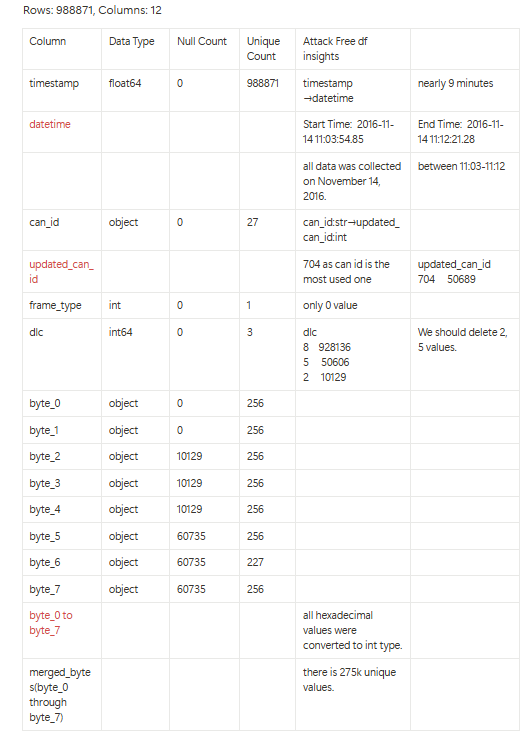

## Import data again

In [54]:
dos_df,fuzzy_df,attack_free_df=load_data("out_paths",lib="pd")


## Only Dos DF and its' Attack Free DF

- In dos attack df, there is both attack free and dos df. We may divide them and analyze separetly.

### Only Dos DF

In [55]:
only_dos_df=dos_df[dos_df["updated_flag"]=='T']

In [56]:
show_shape_info_of_data(only_dos_df)

Data Shape
****************************************
Rows: 587521, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0        587521
      can_id    object           0             1
         dlc     int64           0             1
      byte_0    object           0             1
      byte_1    object           0             1
      byte_2    object           0             1
      byte_3    object           0             1
      byte_4    object           0             1
      byte_5    object           0             1
      byte_6    object           0             1
      byte_7    object           0             1
updated_flag    object           0             1


In [57]:
only_dos_df=convert_timestamp_to_datetime("datetime","timestamp", only_dos_df)
print_start_end_timestamps(only_dos_df,"datetime")

Start Time:  2016-11-03 18:39:37.185137033
End Time:  2016-11-03 19:17:31.438389063


C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\3682863131.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')


In [58]:
col="can_id"
only_dos_df["updated_can_id"] = only_dos_df[col].apply(convert_hex_to_int)
only_dos_df["updated_can_id"].unique()

C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\1313870916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_dos_df["updated_can_id"] = only_dos_df[col].apply(convert_hex_to_int)


array([0])

In [59]:
col="dlc"
only_dos_df[col].unique()

array([8])

In [60]:
[print(only_dos_df[byte].unique()) for byte in bytes_col_list]

['00']
['00']
['00']
['00']
['00']
['00']
['00']
['00']


[None, None, None, None, None, None, None, None]

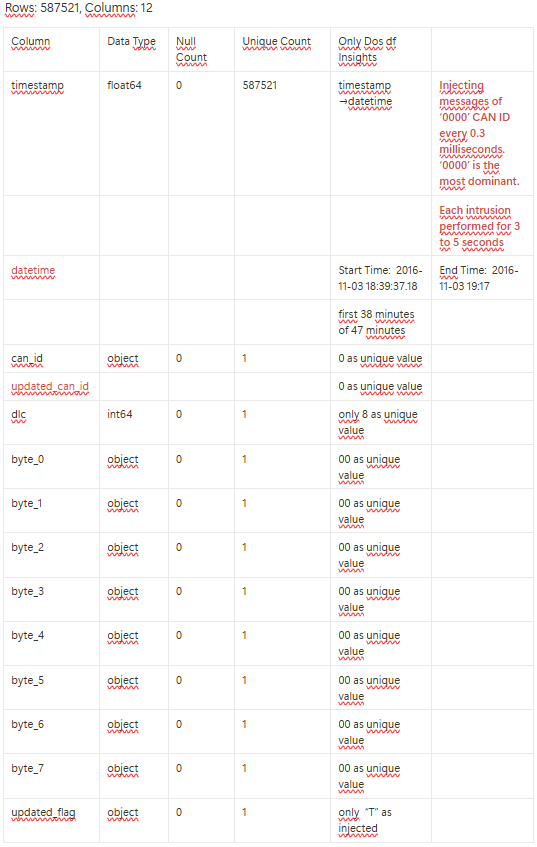

### Only Attack Free DF inside Dos DF

In [61]:
attack_free_df_inside_dos_df=dos_df[dos_df["updated_flag"]=='R']


In [62]:
show_shape_info_of_data(attack_free_df_inside_dos_df)

Data Shape
****************************************
Rows: 3078249, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0       3078249
      can_id    object           0            26
         dlc     int64           0             2
      byte_0    object           0           108
      byte_1    object           0            71
      byte_2    object       31188            75
      byte_3    object       31188            26
      byte_4    object       31188           190
      byte_5    object       31188           256
      byte_6    object       31188            75
      byte_7    object       31188           256
updated_flag    object           0             1


In [63]:
attack_free_df_inside_dos_df=convert_timestamp_to_datetime("datetime","timestamp", attack_free_df_inside_dos_df)

print_start_end_timestamps(attack_free_df_inside_dos_df,"datetime")

Start Time:  2016-11-03 18:39:36.389636040
End Time:  2016-11-03 19:26:49.058943987


C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\3682863131.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')


In [64]:
col="dlc"
attack_free_df_inside_dos_df[col].value_counts()

dlc
8    3047061
2      31188
Name: count, dtype: int64

In [65]:
col="can_id"
attack_free_df_inside_dos_df["updated_can_id"] = attack_free_df_inside_dos_df[col].apply(convert_hex_to_int)

C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\108286545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_free_df_inside_dos_df["updated_can_id"] = attack_free_df_inside_dos_df[col].apply(convert_hex_to_int)


In [66]:
#attack_free_df_inside_dos_df["updated_can_id"].value_counts()

In [67]:
attack_free_df_inside_dos_df=convert_hex_bytes_to_int(attack_free_df_inside_dos_df,bytes_col_list)

C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\3573853339.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(convert_hex_to_int)


In [68]:
attack_free_df_inside_dos_df[bytes_col_list].head()

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7
0,254,91,0.0,0.0,0.0,60.0,0.0,0.0
1,25,33,34.0,48.0,8.0,142.0,109.0,58.0
2,100,0,154.0,29.0,151.0,2.0,189.0,0.0
3,64,187,127.0,20.0,17.0,32.0,0.0,20.0
4,216,0,0.0,138.0,0.0,0.0,0.0,0.0


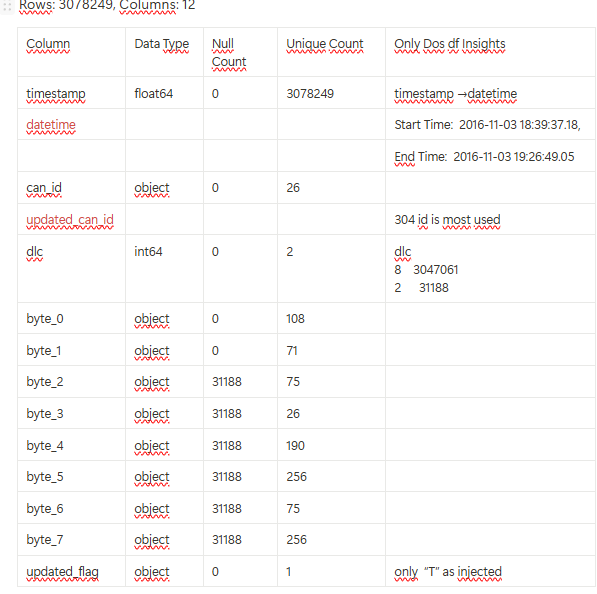

## Only Fuzzy df and it's Attack Free df

In [69]:
only_fuzzy_df=fuzzy_df[fuzzy_df["updated_flag"]=='T']

### Only Fuzzy DF

In [70]:
show_shape_info_of_data(only_fuzzy_df)

Data Shape
****************************************
Rows: 491847, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0        491847
      can_id    object           0          2048
         dlc     int64           0             1
      byte_0    object           0           256
      byte_1    object           0           256
      byte_2    object           0           256
      byte_3    object           0           256
      byte_4    object           0           256
      byte_5    object           0           256
      byte_6    object           0           256
      byte_7    object           0           256
updated_flag    object           0             1


In [71]:
only_fuzzy_df=convert_timestamp_to_datetime("datetime","timestamp", only_fuzzy_df)
print_start_end_timestamps(only_fuzzy_df,"datetime")

Start Time:  2016-11-03 17:55:22.775131941
End Time:  2016-11-03 18:36:17.328352928


C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\3682863131.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')


In [72]:
col="can_id"
only_fuzzy_df["updated_can_id"] = only_fuzzy_df[col].apply(convert_hex_to_int)

C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\1695648100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_fuzzy_df["updated_can_id"] = only_fuzzy_df[col].apply(convert_hex_to_int)


In [73]:
#only_fuzzy_df["updated_can_id"].value_counts()[:30]

In [74]:
col="dlc"
only_fuzzy_df[col].unique()

array([8])

### Only Attack Free DF inside Fuzzy Df

In [75]:
attack_free_df_inside_fuzzy_df=fuzzy_df[fuzzy_df["updated_flag"]=='R']


In [76]:
show_shape_info_of_data(attack_free_df_inside_fuzzy_df)

Data Shape
****************************************
Rows: 3347012, Columns: 12

Info
****************************************
      Column Data Type  Null Count  Unique Count
   timestamp   float64           0       3347012
      can_id    object           0            38
         dlc     int64           0             4
      byte_0    object           0           113
      byte_1    object           0           116
      byte_2    object       34382           115
      byte_3    object       34382            35
      byte_4    object       34382           216
      byte_5    object       87833           256
      byte_6    object       87836           103
      byte_7    object       87836           256
updated_flag    object           0             1


In [77]:
attack_free_df_inside_fuzzy_df=convert_timestamp_to_datetime("datetime","timestamp", attack_free_df_inside_fuzzy_df)

print_start_end_timestamps(attack_free_df_inside_fuzzy_df,"datetime")

Start Time:  2016-11-03 17:55:21.905735970
End Time:  2016-11-03 19:26:49.058943987


C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\3682863131.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_to_be_added_name] = pd.to_datetime(data[existing_col_name], unit='s')


In [78]:
col="dlc"
attack_free_df_inside_fuzzy_df[col].value_counts()

dlc
8    3259176
5      53451
2      34382
6          3
Name: count, dtype: int64

In [79]:
col="can_id"
attack_free_df_inside_fuzzy_df["updated_can_id"] = attack_free_df_inside_fuzzy_df[col].apply(convert_hex_to_int)

C:\Users\Naz\AppData\Local\Temp\ipykernel_6524\1317950146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_free_df_inside_fuzzy_df["updated_can_id"] = attack_free_df_inside_fuzzy_df[col].apply(convert_hex_to_int)


In [80]:
attack_free_df_inside_fuzzy_df["updated_can_id"].value_counts()[:20]

updated_can_id
790     181898
2       179770
399     179536
704     179383
1087    179288
848     178441
304     177930
339     177913
608     177800
880     177421
672     176924
305     175844
809     175487
1088    175236
320     174936
1349    173455
1072     92692
1201     89872
497      89529
1264     88700
Name: count, dtype: int64

In [81]:
attack_free_df_inside_fuzzy_df["updated_can_id"].value_counts()[20:]

updated_can_id
688     53248
1520    34382
160     18035
161     17676
1680    17624
1440     1739
1442     1709
1999      217
1706      203
2009       30
2025       23
2024       19
2010       16
2014       15
1544        7
1819        5
1697        5
261         4
Name: count, dtype: int64